# GARCH

## Load data

In [256]:
%pip install arch


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [257]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import random
from arch import arch_model

In [258]:
df = pd.read_csv('SP_500_Historical_Data.csv', usecols = ['Price']).iloc[::-1].reset_index(drop=True)
df.Price = df['Price'].map(lambda x: float(x.replace(',','')))
df['Log_Return'] = np.log(df.Price) - np.log(df.Price.shift(1))

## General function Garch(1, 1)

In [259]:
def general_garch(returns):
    initial_params = [0.0001, 0.1, 0.8] # Initial omega, alpha, beta

    def garch_likelihood(parameters, ret):
        omega_par, alpha_par, beta_par = parameters
        T = len(ret)
        sigma_squared = np.zeros(T)

        sigma_squared[0] = max(omega_par / (1 - alpha_par - beta_par), 1e-10)
        for t in range(1, T):
            sigma_squared[t] = omega_par + alpha_par * ret[t-1]**2 + beta_par * sigma_squared[t-1]

        log_likelihood = -0.5 * np.sum(np.log(sigma_squared) + (ret**2 / sigma_squared))
        return -log_likelihood 

    result = opt.minimize(garch_likelihood, initial_params, bounds=[[0, None], [0, 1], [0, 1]], args=(returns, ))
    
    #Parameters
    omega, alpha, beta = result.x

    #Standard Errors
    hessian_matrix = result.hess_inv.todense()
    se_omega, se_alpha, se_beta = np.sqrt(np.diag(hessian_matrix))

    #Filtered Variance Process
    T = len(returns)
    sigma_sq = np.zeros(T)
    sigma_sq[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        sigma_sq[t] = omega + alpha * returns[t-1]**2 + beta * sigma_sq[t-1]

    return omega, alpha, beta, se_omega, se_alpha, se_beta, sigma_sq

## GARCH(1, 1) estimation on SP 500

In [260]:
returns = 100*df.Log_Return.dropna().reset_index(drop=True)
omega, alpha, beta, se_omega, se_alpha, se_beta, sigma_squared = general_garch(returns)

In [261]:
print("Estimated parameters:")
print("Alpha:", alpha)
print("Beta:", beta)
print("Omega:", omega)

print("\nStandard errors:")
print("SE Alpha:", se_alpha)
print("SE Beta:", se_beta)
print("SE Omega:", se_omega)

Estimated parameters:
Alpha: 0.15321478323998924
Beta: 0.8279749368496093
Omega: 0.029531238000930927

Standard errors:
SE Alpha: 0.09922893384301784
SE Beta: 0.11372647332496771
SE Omega: 0.04088672598983455


### Library model

In [262]:
model = arch_model(returns, vol='Garch', p=1, q=1)
result = model.fit(disp='off', show_warning=False, options={'ftol': 1e-08})
volatility = result.conditional_volatility
print(result)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5012.40
Distribution:                  Normal   AIC:                           10032.8
Method:            Maximum Likelihood   BIC:                           10057.7
                                        No. Observations:                 3773
Date:                Fri, Jan 19 2024   Df Residuals:                     3772
Time:                        19:59:49   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0774  1.265e-02      6.117  9.530e-10 [5.257e-0

## Simulating a 95% confidence interval

In [263]:
def simulate_future_returns(ret, sigma_sq, omega, alpha, beta, num_days=30):
    future_returns = np.zeros(num_days)
    future_volatility = np.zeros(num_days)
    
    random.seed(42)
    
    for t in range(num_days):
        if t == 0:
            future_volatility[t] = omega + alpha * ret**2 + beta * sigma_sq
            future_returns[t] = np.sqrt(sigma_sq) * np.random.normal()
        else:
            future_volatility[t] = omega + alpha * future_returns[t-1]**2 + beta * future_volatility[t-1]
            future_returns[t] = np.sqrt(future_volatility[t-1]) * np.random.normal()

    return future_returns, future_volatility

In [264]:
future_returns = np.zeros((len(returns), 30)) 
future_volatility = np.zeros((len(returns), 30))
for i in range(len(returns)):
    future_returns[i], future_volatility[i] = simulate_future_returns(returns[i], sigma_squared[i], omega, alpha, beta)


In [265]:
def calculate_confidence_interval(simulated_returns, confidence_level=0.95):
    lower_bound = np.percentile(simulated_returns, (1 - confidence_level) / 2 * 100, axis=0)
    upper_bound = np.percentile(simulated_returns, (1 + confidence_level) / 2 * 100, axis=0)

    return lower_bound, upper_bound

In [266]:
lower_bounds_volatility = np.zeros(len(returns))
upper_bounds_volatility = np.zeros(len(returns))

for i in range(len(returns)):
    lower_bounds_volatility[i], upper_bounds_volatility[i] = calculate_confidence_interval(future_volatility[i])

In [267]:
lower_bounds_returns= np.zeros(len(returns))
upper_bounds_returns = np.zeros(len(returns))

for i in range(len(returns)):
    lower_bounds_returns[i], upper_bounds_returns[i] = calculate_confidence_interval(future_returns[i])

## Confidence interval violation

In [268]:
num_days = len(returns)
violations = np.sum((sigma_squared < lower_bounds_volatility) | (sigma_squared > upper_bounds_volatility))
violation_percentage = violations * 100 / len(returns)
    
print(f"Number of violations in the 30-day prediction period: {violations}")
print(f"Percentage of violations: {violation_percentage:.2f}%")

Number of violations in the 30-day prediction period: 912
Percentage of violations: 24.17%


In [270]:
violations = np.sum((sigma_squared < lower_bounds_returns) | (sigma_squared > upper_bounds_returns))
violation_percentage = violations * 100 / len(returns)
    
print(f"Number of violations in the 30-day prediction period: {violations}")
print(f"Percentage of violations: {violation_percentage:.2f}%")

Number of violations in the 30-day prediction period: 642
Percentage of violations: 17.02%


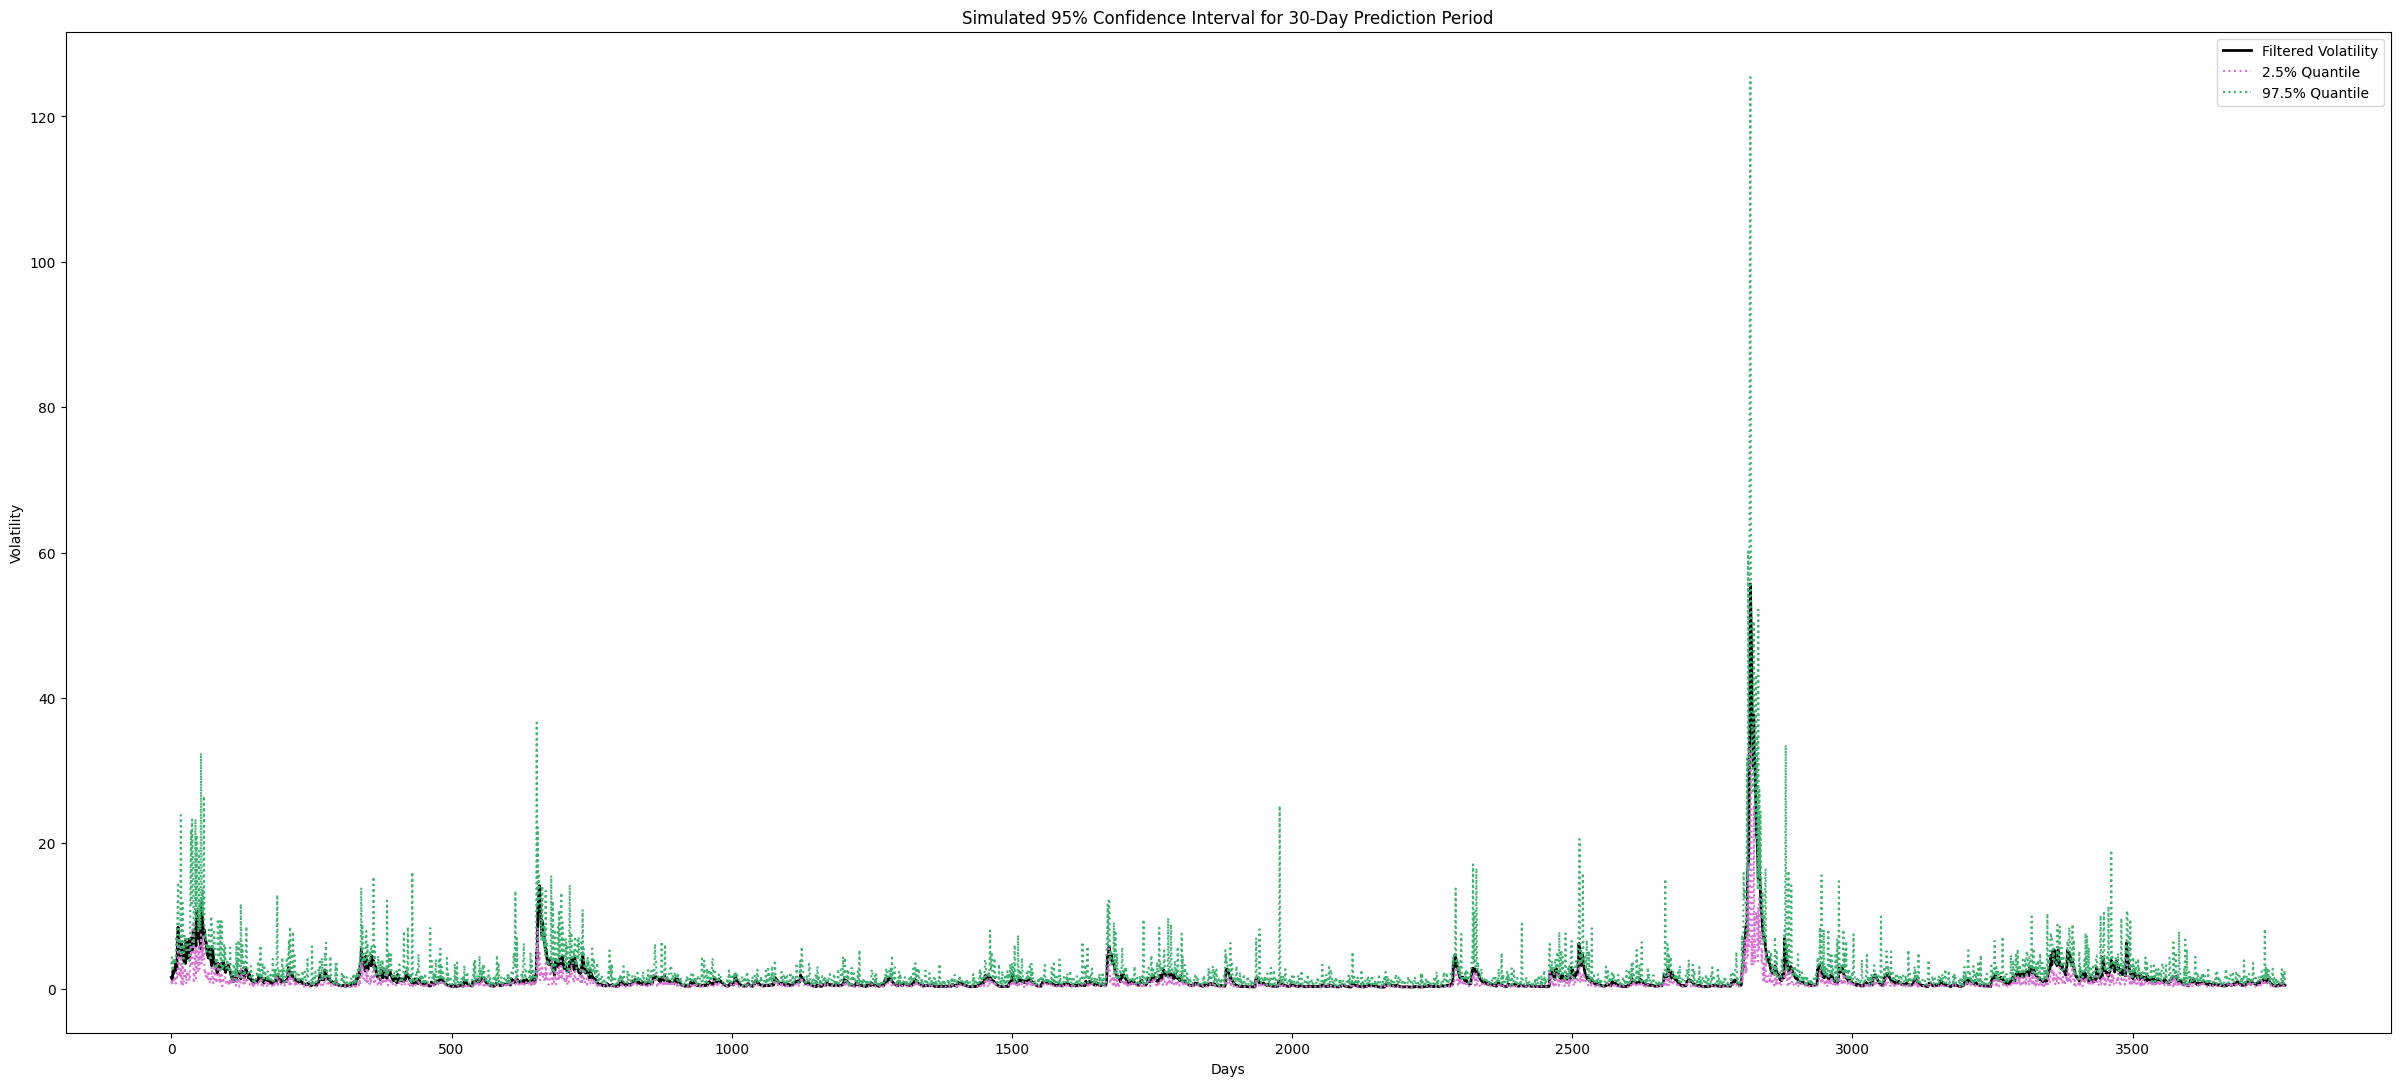

In [297]:
plt.figure(figsize=(30, 13))
plt.plot(sigma_squared, label='Filtered Volatility', color='black', linewidth = 2)
plt.plot(lower_bounds_volatility, label='2.5% Quantile', linestyle='dotted', color='orchid')
plt.plot(upper_bounds_volatility, label='97.5% Quantile', linestyle='dotted', color='mediumseagreen')
plt.title('Simulated 95% Confidence Interval of Volatilities for 30-Day Prediction Period')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()

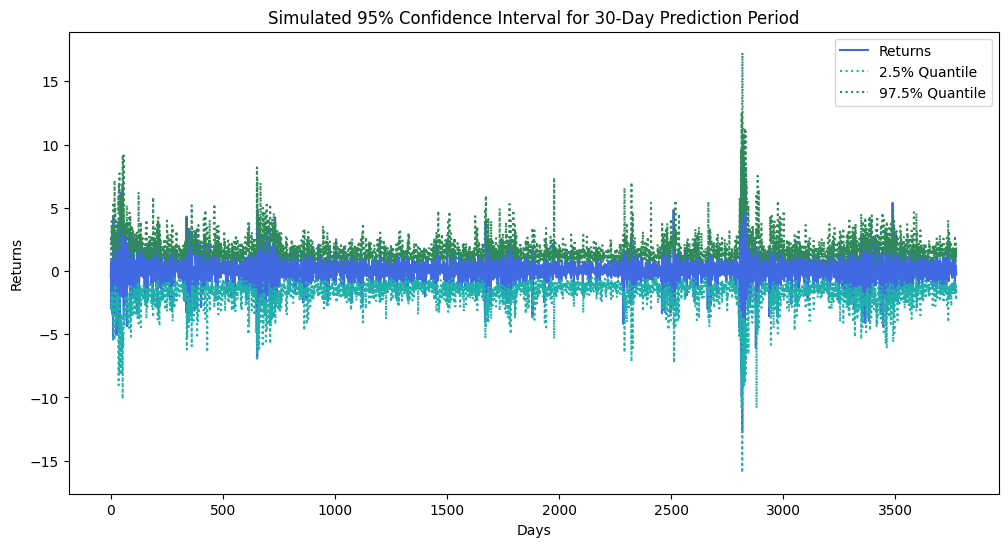

In [303]:
plt.figure(figsize=(12, 6))
plt.plot(returns, label='Returns', color='royalblue')
plt.plot(lower_bounds_returns, label='2.5% Quantile', linestyle='dotted', color='lightseagreen')
plt.plot(upper_bounds_returns, label='97.5% Quantile', linestyle='dotted', color='seagreen')
plt.title('Simulated 95% Confidence Interval for 30-Day Prediction Period')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()